<h1><center>Programowanie Zespołowe</center></h1>
<h2><center>Klasyfikator grzybów</center></h2>
<h3><center>Autorzy: Agata Groszek, Dawid Nowak, Krzysztof Dobrucki, Mateusz Bystroński</center></h3>

## Motywacja

Nieznajomość zbieranych, a następnie zjadanych grzybów jest najczęstszą przyczyną zatrucia organizmu. Więcej o niebezpieczeństwach $\rightarrow$ <a href="https://www.gov.pl/web/psse-szczecin/zatrucie-grzybami--objawy-i-pierwsza-pomoc">tutaj</a>.<br>
Zatem uznaliśmy, że istnieje zapotrzebowanie na narzędzie, które będzie w stanie poprawnie zidentyfikować, które grzyby są jadalne (wraz z gatunkiem), a których należy unikać.

## Wstęp

Ludzie określają gatunek grzyba głównie na podstawie jego wyglądu (np. kolor, kształt) zatem chcemy stworzyć model, który na podstawie dostarczonych zdjęć będzie zwracać gatunek grzyba. 

W tym celu znaleźliśmy dataset zawierający grzyby występujące w Rosji (ze względu na bliską odległość geograficzną) i zweryfikowaliśmy ich występowanie w Polsce. Dostęp do datasetu $\rightarrow$ <a href="https://www.kaggle.com/datasets/thehir0/mushroom-species"> tutaj</a>.

Chcemy stworzyć klasyfikator, który rozpoznaje obiekty, poprzez wytrenowanie sieci neuronowej.

## Wybór modelu

Tworzenie własnego modelu od podstaw wymagałoby dużego nakładu pracy i prawdopodobnie przyniosło marne skutki, zatem lepiej skorzystać ze sprawdzonych rozwiązań.

### ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

Challenge, na którym realizowane są następujące zadania:
1. Image classification: Predict the classes of objects present in an image.
2. Single-object localization: Image classification + draw a bounding box around one example of each object present.
3. Object detection: Image classification + draw a bounding box around each object present.

Modele przedstawiane w tym challenge'u są dobrze przystosowane pod nasze wymagania projektowe, więc weźmy najlepiej sprawujące się architektury, przetrenujmy każdą w ten sam sposób na danych z naszego datasetu i porównajmy otrzymane wyniki.

###### <a href="https://www.kaggle.com/discussions/getting-started/149448"> https://www.kaggle.com/discussions/getting-started/149448</a>

Będziemy korzystać z przetrenowanych modeli z biblioteki ```pytorch```. Spójrzmy na kandydatów na architekturę modelu:

| model | liczba parametrów | acc@1 | acc@5 |
| --- | --- | --- | --- |
| RESNEXT50_32X4D | 25028904 | 77.618 | 93.698 |
| RESNEXT101_32X8D | 88791336 | 79.312| 94.526 |
| RESNEXT101_64X4D | 83455272 | 83.246 | 96.454|
| RESNET50 | 25557032 | 76.13 | 92.862 |
| RESNET101 | 44549160 | 77.374 | 93.546 |
| EFFICIENTNET_B6 | 43040704 | 84.008 | 96.916 |
| EFFICIENTNET_V2_L | 118515272 | 85.808 | 	97.788 |
| EFFICIENTNET_B7 |	66347960 | 	84.122 | 96.908 |

Ze względu na ograniczenia czasowe i sprzętowe wybieramy modele o liczbie parametrów $< 5000000$

Do uczenia modelu wykorzystamy ```StratifiedKFold```. Dzielimy dane na $k$ części, gdzie w każdej z $k$ iteracji jedna porcja jest wykorzystywana jako zbiór testowy, a pozostałe $k-1$ porcji jako zbiór treningowy. Dane są dzielone na części w taki sposób aby został zachowany % klas.

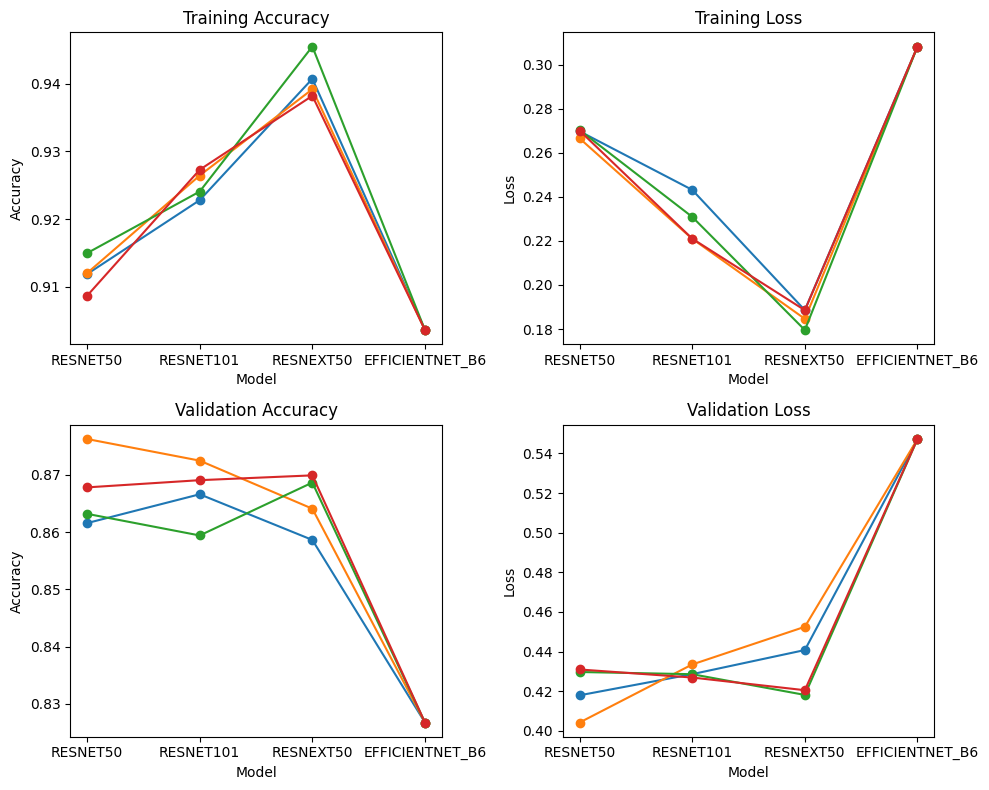

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 

names = ["RESNET50", "RESNET101","RESNEXT50", "EFFICIENTNET_B6"]
training_acc_1 = [0.9118881225585938, 0.9227972030639648, 0.9406992793083191, 0.9036363363265991]
training_acc_2 = [0.9120279550552368, 0.9264335632324219, 0.9391608238220215, 0.9036363363265991]
training_acc_3 = [0.914976954460144, 0.9240665435791016, 0.945462167263031, 0.9036363363265991]
training_acc_4 = [0.9086840748786926, 0.9272828698158264, 0.9381904602050781, 0.9036363363265991]

training_loss_1 = [0.2697286009788513, 0.24314793944358826, 0.18858984112739563, 0.30817195773124695]
training_loss_2 = [0.2665235996246338, 0.22097131609916687, 0.18463973701000214, 0.30817195773124695]
training_loss_3 = [0.27029621601104736, 0.23090240359306335, 0.1795613318681717, 0.30817195773124695]
training_loss_4 = [0.2700299322605133, 0.22102408111095428, 0.18855690956115723, 0.30817195773124695]

val_acc_1 = [0.8615771532058716, 0.8666107654571533, 0.8586409687995911, 0.8267617225646973]
val_acc_2 = [0.876258373260498, 0.8724831938743591, 0.8640939593315125, 0.8267617225646973]
val_acc_3 = [0.8631976246833801, 0.859420895576477, 0.8686529397964478, 0.8267617225646973]
val_acc_4 = [0.8678137063980103, 0.8690726161003113, 0.8699118494987488, 0.8267617225646973]

val_loss_1 = [0.41795995831489563, 0.42862963676452637, 0.44079816341400146, 0.5472736358642578]
val_loss_2 = [0.4042189121246338, 0.43352067470550537, 0.4525250792503357, 0.5472736358642578]
val_loss_3 = [0.42971858382225037, 0.4286092519760132, 0.41815462708473206, 0.5472736358642578]
val_loss_4 = [0.4309932291507721, 0.4269370138645172, 0.4205342233181, 0.5472736358642578]

t_1 = [600.716992855072, 633.8906571865082, 515.6420872211456, 5388.297246217728]
t_2 = [479.2812888622284, 690.445793390274, 512.2152326107025, 5388.297246217728]
t_3 = [580.6437463760376, 690.9319121837616, 621.2117245197296, 5388.297246217728]
t_4 = [531.6910197734833, 567.9668481349945, 459.7076225280762, 5388.297246217728]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plotting each metric on its subplot
axs[0, 0].plot(names, training_acc_1, marker='o', linestyle='-')
axs[0, 0].plot(names, training_acc_2, marker='o', linestyle='-')
axs[0, 0].plot(names, training_acc_3, marker='o', linestyle='-')
axs[0, 0].plot(names, training_acc_4, marker='o', linestyle='-')
axs[0, 0].set_title('Training Accuracy')
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('Accuracy')

axs[0, 1].plot(names, training_loss_1, marker='o', linestyle='-')
axs[0, 1].plot(names, training_loss_2, marker='o', linestyle='-')
axs[0, 1].plot(names, training_loss_3, marker='o', linestyle='-')
axs[0, 1].plot(names, training_loss_4, marker='o', linestyle='-')
axs[0, 1].set_title('Training Loss')
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('Loss')

axs[1, 0].plot(names, val_acc_1, marker='o', linestyle='-')
axs[1, 0].plot(names, val_acc_2, marker='o', linestyle='-')
axs[1, 0].plot(names, val_acc_3, marker='o', linestyle='-')
axs[1, 0].plot(names, val_acc_4, marker='o', linestyle='-')
axs[1, 0].set_title('Validation Accuracy')
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('Accuracy')

axs[1, 1].plot(names, val_loss_1, marker='o', linestyle='-')
axs[1, 1].plot(names, val_loss_2, marker='o', linestyle='-')
axs[1, 1].plot(names, val_loss_3, marker='o', linestyle='-')
axs[1, 1].plot(names, val_loss_4, marker='o', linestyle='-')
axs[1, 1].set_title('Validation Loss')
axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('Loss')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


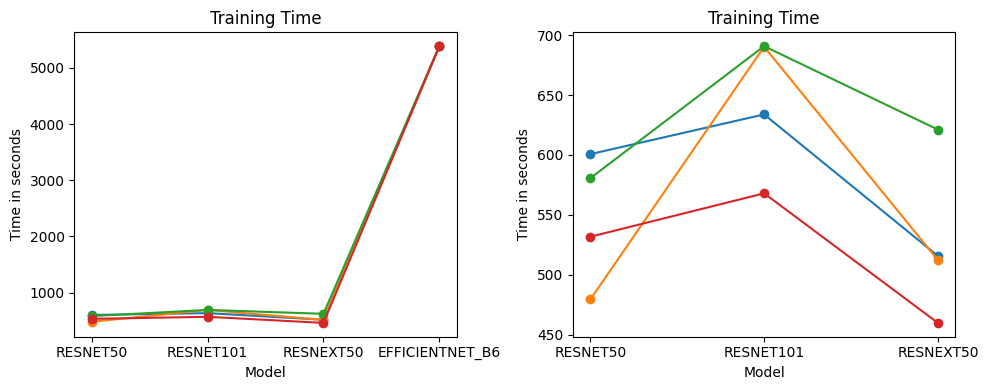

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(names, t_1, marker='o', linestyle='-')
axs[0].plot(names, t_2, marker='o', linestyle='-')
axs[0].plot(names, t_3, marker='o', linestyle='-')
axs[0].plot(names, t_4, marker='o', linestyle='-')
axs[0].set_title('Training Time')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Time in seconds')
axs[1].plot(names[:-1], t_1[:-1], marker='o', linestyle='-')
axs[1].plot(names[:-1], t_2[:-1], marker='o', linestyle='-')
axs[1].plot(names[:-1], t_3[:-1], marker='o', linestyle='-')
axs[1].plot(names[:-1], t_4[:-1], marker='o', linestyle='-')
axs[1].set_title('Training Time')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Time in seconds')
# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

**Uwaga: Ze wolną prędkość uczenia model EFFICIENTNET_B6 został przetrenowany tylko na jednym podziale z parametrem ```max_epochs``` = 5 (dla pozostałych =10)**

Żaden z modeli nie uzyskał satysfakcjonującej dokładności.

## Realizacja

Ponieważ, żaden z testowanych modeli nie osiągnął wytarczająco dobrych wyników to postanowiliśmy podzielić dataset ze względu na to jakie cechy grzyba są widoczne na zdjęciu (kapelusz, nóżka, spód kapelusza) i stworzyć klasyfikatory "eksperci" wytrenowane na wyselekcjonowanych danych. Następnie stworzyliśmy klasyfikator końcowy, który bierze jako input 3 zdjęcia (z widocznymi odpowiednimi cechami) i na podstawie wyników zwróconych przez ekspertów stwierdza klasę grzyba.

Do treningu wykorzystaliśmy model ```RESNET50```, który osiągnął najlepsze wyniki na zbiorze walidacyjnym.

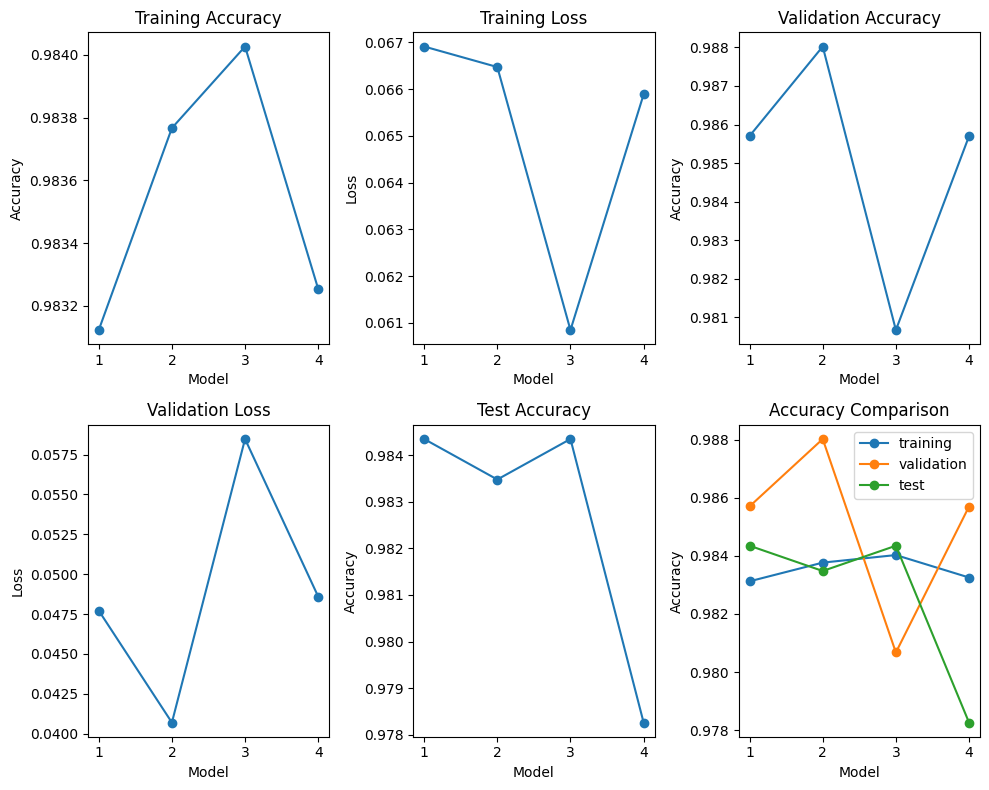

In [22]:
n=[1,2,3,4]
acc = [0.983123, 0.983767, 0.984027, 0.983254]
val_acc = [0.985703, 0.988022, 0.980673, 0.985698]
loss=[0.066909, 0.066470, 0.060845, 0.065884]
val_loss =[0.047720, 0.040702, 0.058479, 0.048601]
t_acc=[0.9843478202819824, 0.9834782481193542, 0.9843478202819824, 0.97826087474823]
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

# Plotting each metric on its subplot
axs[0, 0].plot(n, acc, marker='o', linestyle='-')
axs[0, 0].set_title('Training Accuracy')
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('Accuracy')

axs[0, 1].plot(n, loss, marker='o', linestyle='-')
axs[0, 1].set_title('Training Loss')
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('Loss')

axs[0, 2].plot(n, val_acc, marker='o', linestyle='-')
axs[0, 2].set_title('Validation Accuracy')
axs[0, 2].set_xlabel('Model')
axs[0, 2].set_ylabel('Accuracy')

axs[1, 0].plot(n, val_loss, marker='o', linestyle='-')
axs[1, 0].set_title('Validation Loss')
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('Loss')

axs[1, 1].plot(n, t_acc, marker='o', linestyle='-')
axs[1, 1].set_title('Test Accuracy')
axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('Accuracy')

axs[1, 2].plot(n, acc, marker='o', linestyle='-', label="training")
axs[1, 2].plot(n, val_acc, marker='o', linestyle='-', label="validation")
axs[1, 2].plot(n, t_acc, marker='o', linestyle='-', label="test")
axs[1, 2].set_title('Accuracy Comparison')
axs[1, 2].set_xlabel('Model')
axs[1, 2].set_ylabel('Accuracy')
axs[1, 2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()


# Show plot
plt.show()

Otrzymane wyniki są znacznie lepsze od resultatów otrzymanych przy porównywaniu modeli, jednakże dokładność jest wciąż zbyt niska biorąc pod uwagę możliwość zatrucia na skutek pomyłki.

## Struktura Projektu

#### Projekt:

- dispaly.py
- train_cap.py
- train_cap_2.py
- train_final.py
- ai
    - RsNet101Model.py
    - RsNet50Model.py
    - model.py
    - transforms.py
    - utils.py
- scripts
    - display.py
    - preprocess_feature_classification.py
    - preprocess_features.py
    - preprocess_features_for_final.py

#### Charakterystyka plików:

*display.py*: Zawiera definicje ścieżek do checkpointu oraz bazy danych, wczytuje model i przetwarza zdjęcia za pomocą transformacji, a następnie przeprowadza inferencję na modelu, wypisując przewidziane klasy i prawdopodobieństwa dla każdego zdjęcia.

*train_cap.py*: Odpowiada za trenowanie modelu klasyfikacji grzybów z użyciem architektury ResNet50 wraz z techniką walidacji krzyżowej oraz wczesnego zatrzymywania. Zbiór danych jest dzielony na zbiór treningowy, walidacyjny i testowy, a następnie przeprowadzane są iteracje treningowe na każdym z etapów walidacji krzyżowej, oceniając zarówno stratę, jak i dokładność.

*train_cap_2.py*: Odpowiada za trenowanie modelu klasyfikacji grzybów z użyciem architektury ResNet101 wraz z techniką walidacji krzyżowej oraz wczesnego zatrzymywania. Zbiór danych jest dzielony na zbiór treningowy, walidacyjny i testowy, a następnie przeprowadzane są iteracje treningowe na każdym z etapów walidacji krzyżowej, oceniając zarówno stratę, jak i dokładność.

*train_final.py*: Trenuje model klasyfikacji grzybów z użyciem architektury ResNet101 oraz techniki walidacji krzyżowej. Dane są dzielone na zbiór treningowy, walidacyjny i testowy. Następnie przeprowadzane są iteracje treningowe na każdym etapie walidacji krzyżowej, a wyniki (strata i dokładność) są zapisywane dla każdego złożenia walidacji krzyżowej.

*./scripts*: Proste skrytpy zapewniające odpowiednie formatowanie bazy danych - wszelkie szczegóły w README.md.

*./ai*: Klasy odpowiedzialne za rozszerzanie domyślnych klas pakietu ResNet zgodnie z potrzebami projektu.

Wszelkie dalsze dane znajduą się w dokumetacji kodu. Cały kod posiada komentarze dla łatwiejszego zorientowania się w projekcie.


## Eliminowanie False Positive

Największym zagrożeniem dla użytkownika końcowego produktu jest błąd *False Positive*, czyli gdy model rozpozna trującego grzyba jako jadalnego. Aby zminimalizować takie ryzyko przetestowano trzy możliwości przeciwdziałania (wykresy trafności poniżej):

- dodatkowy klasyfikator, który włącza się w przypadku wątpliwości podstawowego modelu zbudowany w oparciu o ResNet50Model.
- analogiczny klasyfikator jak punk wyżej, ale w oparciu o ResNet101Model
- analiza wag trzech ekspertów i ewaluacja na ich podstawie



![Alt text](train_a.png) ![Alt text](train_l.png) ![Alt text](val_a.png) ![Alt text](val_l.png) ![Alt text](test_a.png) ![Alt text](comp.png)

Jak wynika z powyższych danych, aby chronić użytkowników końcowych należało zastosować prostszą opcję (możliwość trzecia) kosztem średniej poprawności predykcji modelu. Powodem takich wyników może być niesatysfakcjonująca liczba danych dla wszytskich gatunków grzybów - wybrana technologia nawet w przypadku zastosowania "eksperta od trudnych przypadków" nie dała rady w satysfakcjonujący sposób wyeliminować podanego błędu, najczęściej mylone były te same obiekty co w podstawowym klasyfikatorze.

## Podsumowanie

Projekt polegał na wykorzystaniu architektury ResNet do rozpoznawania gatunku grzybów na podstawie zdjęć. ResNet jest głęboką architekturą sieci neuronowej, która jest znana z dobrych wyników w zadaniach klasyfikacji obrazów. W projekcie zaimplementowano model ResNet, który został wytrenowany na zbiorze danych zawierającym zdjęcia różnych gatunków grzybów.

Mimo początkowych obiecujących wyników, projekt wymaga dalszych dopracowań. Istnieje kilka obszarów, które mogłyby być ulepszone:
1. **Zwiększenie zbioru danych:** Aby poprawić generalizację modelu, należy rozważyć zwiększenie zbioru danych treningowych. Większy i bardziej zróżnicowany zbiór danych może pomóc w lepszym nauczeniu modelu.

2. **Tuning hiperparametrów:** Dalsze eksperymenty z różnymi hiperparametrami modelu mogą pomóc w osiągnięciu lepszych wyników. Należy eksperymentować z parametrami uczenia się, rozmiarem batcha, regularyzacją itp.

3. **Wykorzystanie transfer learningu:** Można rozważyć wykorzystanie transfer learningu z już wytrenowanymi modelami ResNet na dużych zbiorach danych obrazowych, co może przyspieszyć uczenie się modelu oraz poprawić wyniki.

4. **Lepsza analiza błędów:** Ważne jest dokładne zrozumienie, w jaki sposób model się myli, aby móc poprawić jego skuteczność. Analiza błędów może pomóc zidentyfikować trudne przypadki i dostosować model do lepszego radzenia sobie z nimi.

Podsumowując, projekt wykorzystujący ResNet do rozpoznawania gatunku grzybów pokazał obiecujące wyniki, ale wymaga dalszych prac rozwojowych w celu poprawy skuteczności i generalizacji modelu.